In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from collections import Counter
from matplotlib.colors import ListedColormap
import scipy.io
import pandas as pd
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from collections import defaultdict,Counter

from lapixdl.evaluation.evaluate import evaluate_segmentation

import json
import pickle
from tqdm.keras import TqdmCallback

np.random.seed(10)

import seaborn as sns

In [2]:
# Constants
PROJECT_FOLDER = './'
DATASET_ZIP_URL = 'https://github.com/ocatak/RadarSpectrumSensing-FL-AML/raw/main/converted_dataset.zip'
DATASET_ZIP_FILE = 'converted_dataset.zip'
DATASET_DIR = './data'
CLASSES = ["Noise", "LTE", "NR", "Radar"]
NUM_CLASSES = len(CLASSES)
INPUT_SHAPE = (256, 256, 3)
NUMBER_OF_CLIENTS = 5
NUMBER_OF_EPOCHS = 3
NUM_ROUNDS = 10

PRINT_SAMPLE_PRED = False
cmp = ListedColormap(['#00FFFF', '#8080FF', '#FF00FF', '#0F00F8'])

In [3]:
# Download dataset using wget and unzip
def download_and_unzip_dataset(zip_url, zip_file, target_dir):
    if not os.path.exists(zip_file):
        print(f'Downloading dataset from {zip_url}...')
        os.system(f'wget -O {zip_file} {zip_url} -q')
    else:
        print(f'Dataset file {zip_file} already exists.')
    
    if not os.path.exists(target_dir):
        print(f'Unzipping dataset file: {zip_file}')
        os.system(f'unzip {zip_file} -d {target_dir}')
    else:
        print(f'Dataset directory {target_dir} already exists.')

# Call the function to download and unzip the dataset
download_and_unzip_dataset(DATASET_ZIP_URL, DATASET_ZIP_FILE, DATASET_DIR)

Dataset file converted_dataset.zip already exists.
Dataset directory ./data already exists.


In [4]:
# Dataset loading and preprocessing
def convert_to_int(filename):
    conv_dict = {'Noise': 0, 'LTE': 1, 'NR': 2, 'Radar': 3}
    with open(filename, 'r') as f:
        data = f.read()
    for key, value in conv_dict.items():
        data = data.replace(key, str(value))
    with open('tmp.txt', 'w') as f:
        f.write(data)
    return pd.read_csv('tmp.txt', sep=',', header=None).values

In [5]:
def load_dataset(dataset_dir, num_files=500):
    X, Y = [], []
    for idx in range(1, num_files):
        spectrogram = scipy.io.loadmat(f'{dataset_dir}/rcvdSpectrogram_{idx}.mat')['rcvdSpectrogram']
        label = convert_to_int(f'{dataset_dir}/trueLabels_{idx}.csv')
        X.append(spectrogram)
        Y.append(label)
    return np.array(X), np.array(Y)

In [6]:
# Federated Learning
def split_data_for_clients(X, Y, num_clients=5):
    client_data = []
    X_split = np.array_split(X, num_clients)
    Y_split = np.array_split(Y, num_clients)
    for i in range(num_clients):
        client_data.append((X_split[i], Y_split[i]))
    return client_data

In [7]:
# Load dataset
X, Y = load_dataset('data/data/convertedFolder')

# Preprocess and split data
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)
x_train, x_val = np.array(x_train), np.array(x_val)
y_train, y_val = np.array(y_train), np.array(y_val)
y_train_onehot = tf.one_hot(y_train.astype(np.int32), depth=NUM_CLASSES)
y_val_onehot = tf.one_hot(y_val.astype(np.int32), depth=NUM_CLASSES)

client_data = split_data_for_clients(x_train, y_train, NUMBER_OF_CLIENTS)

In [8]:
import numpy as np
from collections import defaultdict

# Non-IID data split function for image segmentation (strongly non-IID)
def split_data_strongly_non_iid(X, Y, num_clients=5, num_shards_per_client=2, num_classes=4):
    """Create strongly non-IID distribution of data for clients, where each image has pixel-wise labels.
    
    Args:
        X (np.ndarray): Input data (images).
        Y (np.ndarray): Labels (pixel-wise class labels for each image).
        num_clients (int): Number of clients.
        num_shards_per_client (int): Number of shards per client.
        num_classes (int): Number of classes.
    
    Returns:
        list of tuples: A list where each element is (X_client, Y_client) for each client.
    """
    client_data = []
    num_shards = num_clients * num_shards_per_client

    # Group the data by the most common class in each image
    class_indices = defaultdict(list)
    for i in range(X.shape[0]):
        # Find the most common class in the image
        most_common_class = np.argmax(np.bincount(Y[i].flatten()))
        class_indices[most_common_class].append(i)
    
    # Shuffle the indices within each class
    for class_idx in class_indices:
        np.random.shuffle(class_indices[class_idx])
    
    # Create strongly non-IID shards: assign different classes predominantly to different clients
    shards_per_class = {}
    for class_idx in range(num_classes):
        class_data = class_indices[class_idx]
        if len(class_data) < num_shards_per_client:
            # If there are not enough data points, create shards with smaller sizes
            shards_per_class[class_idx] = [class_data]
        else:
            shards_per_class[class_idx] = np.array_split(class_data, num_shards_per_client)
    
    for client_idx in range(num_clients):
        client_shards = []
        # For each client, assign most of the data from one class and a little from others
        main_class = client_idx % num_classes  # Primary class for this client
        client_shards.extend(shards_per_class[main_class][:num_shards_per_client])
        
        # Add some diversity by assigning a few samples from other classes (just a little)
        for other_class in range(num_classes):
            if other_class != main_class and len(shards_per_class[other_class]) > 0:
                # Take a small amount of data from other classes
                shard_size = len(shards_per_class[other_class][0]) // 5  # Small portion
                if shard_size > 0:  # Ensure the shard has data
                    client_shards.append(shards_per_class[other_class][0][:shard_size])

        # Concatenate all the shards for this client
        if len(client_shards) > 0:
            client_indices = np.concatenate(client_shards).astype(int)  # Ensure indices are integers
            X_client = X[client_indices]
            Y_client = Y[client_indices]
            client_data.append((X_client, Y_client))
    
    return client_data

# Example usage:
client_data = split_data_strongly_non_iid(x_train, y_train, num_clients=5, num_shards_per_client=2, num_classes=NUM_CLASSES)


             Noise      LTE       NR   Radar
Client_0  13718969  2298034  4555669  398848
Client_1   1576704   213124  1038972   54784
Client_2   3304279  1200336  6617049  216064
Client_3   1576704   213124  1038972   54784
Client_4  13718969  2298034  4555669  398848


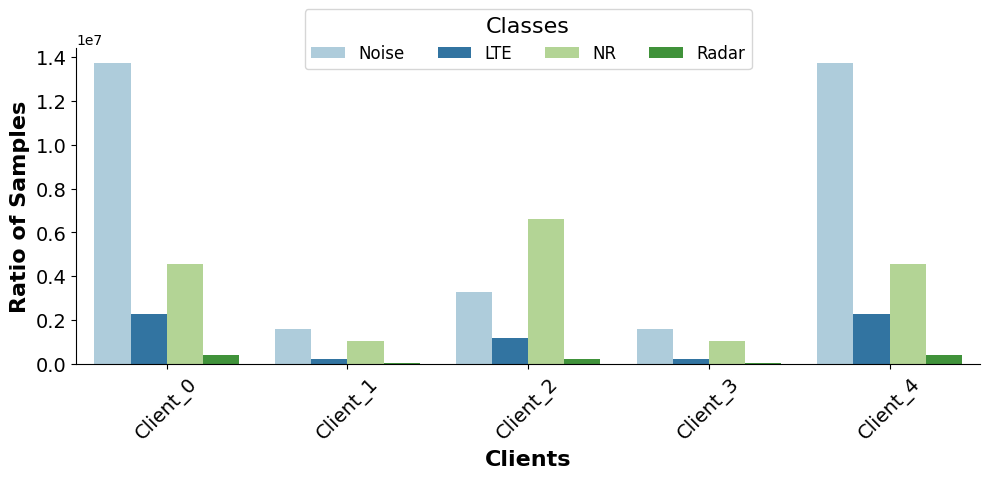

             Noise       LTE        NR     Radar
Client_0  0.654171  0.109579  0.217231  0.019019
Client_1  0.546786  0.073909  0.360306  0.018999
Client_2  0.291441  0.105871  0.583631  0.019057
Client_3  0.546786  0.073909  0.360306  0.018999
Client_4  0.654171  0.109579  0.217231  0.019019


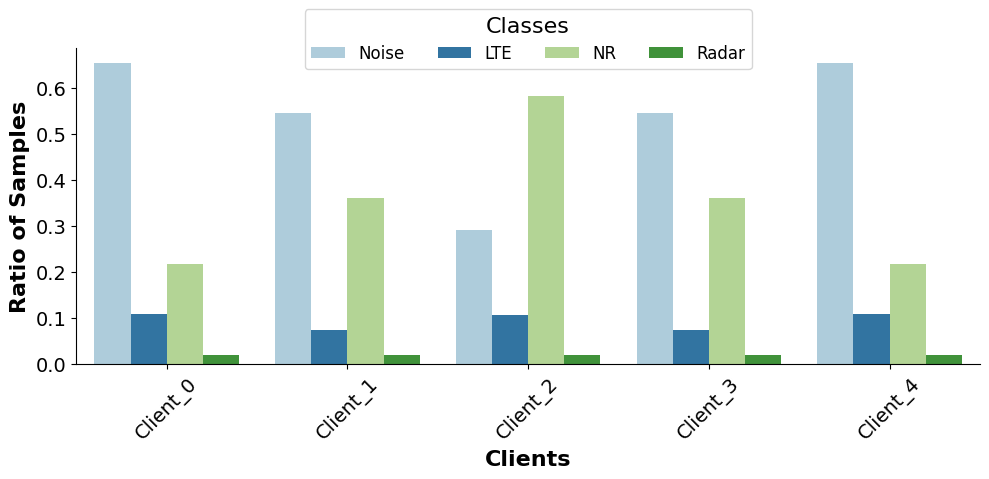

In [9]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to count the number of samples for each class per client (pixel-wise for segmentation)
def check_noniid_distribution(client_data, num_clients, num_classes):
    client_class_counts = []

    for i in range(num_clients):
        _, Y_client = client_data[i]
        
        # Flatten Y_client (which contains pixel-wise labels) to 1D for counting
        Y_client_flat = Y_client.flatten()
        
        # Count the occurrences of each class
        class_counts = Counter(Y_client_flat)

        # Ensure that the count is reported for all classes, even if a class has 0 samples
        class_count_list = [class_counts.get(c, 0) for c in range(num_classes)]
        client_class_counts.append(class_count_list)
    
    # Convert to a DataFrame for easier visualization
    df = pd.DataFrame(client_class_counts, columns=CLASSES)
    df.index = [f'Client_{i}' for i in range(num_clients)]
    
    return df

# Function to visualize the class distribution
def plot_class_distribution(df):
    # Melt the DataFrame for seaborn compatibility (long-form)
    df_long = df.reset_index().melt(id_vars="index", var_name="Class", value_name="Ratio")
    df_long.rename(columns={'index': 'Client'}, inplace=True)

    # Set color palette
    palette = sns.color_palette("Paired", len(CLASSES))

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_long, x="Client", y="Ratio", hue="Class", palette=palette)
    
    # Customizing plot aesthetics
    plt.xlabel("Clients", fontsize=16, weight='bold')
    plt.ylabel("Ratio of Samples", fontsize=16, weight='bold')
    plt.legend(title="Classes", title_fontsize='16', fontsize=12, loc='upper center',
               bbox_to_anchor=(0.5, 1.15), ncol=4)  # Set custom labels here
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Remove top and right spines
    sns.despine()
    
    # Show plot
    plt.tight_layout()
    
    plt.savefig('class_distribution.pdf', bbox_inches='tight')
    plt.show()

# Function to convert class counts to ratios (proportions)
def convert_counts_to_ratios(df):
    """Convert class counts to ratios for each client."""
    # Normalize each row so that the sum of the classes for each client equals 1
    df_ratios = df.div(df.sum(axis=1), axis=0)
    return df_ratios

# Check and visualize the non-IID distribution
distribution_df = check_noniid_distribution(client_data, num_clients=5, num_classes=NUM_CLASSES)
print(distribution_df)
plot_class_distribution(distribution_df)

# Convert counts to ratios
distribution_ratios_df = convert_counts_to_ratios(distribution_df)
print(distribution_ratios_df)

# Optionally, plot the ratios as well
plot_class_distribution(distribution_ratios_df)

In [10]:
# Generate counts and ratios dataframes
distribution_df = check_noniid_distribution(client_data, num_clients=5, num_classes=4)
distribution_ratios_df = convert_counts_to_ratios(distribution_df)

# Combine counts and ratios into a single table
combined_df = pd.DataFrame()

for client in distribution_df.index:
    # Calculate the total number of spectrograms per client
    total_spectrograms = int(distribution_df.loc[client].sum()/65536)
    combined_df.loc[client, 'Total Spectrograms'] = total_spectrograms
    
    for class_label in distribution_df.columns:
        combined_df.loc[client, f'{class_label} # of records'] = distribution_df.loc[client, class_label]
        combined_df.loc[client, f'{class_label} Ratio'] = distribution_ratios_df.loc[client, class_label]

# Print LaTeX code
print(combined_df.to_latex(index=True, multirow=True))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & Total Spectrograms & Noise # of records & Noise Ratio & LTE # of records & LTE Ratio & NR # of records & NR Ratio & Radar # of records & Radar Ratio \\
\midrule
Client_0 & 320.000000 & 13718969.000000 & 0.654171 & 2298034.000000 & 0.109579 & 4555669.000000 & 0.217231 & 398848.000000 & 0.019019 \\
Client_1 & 44.000000 & 1576704.000000 & 0.546786 & 213124.000000 & 0.073909 & 1038972.000000 & 0.360306 & 54784.000000 & 0.018999 \\
Client_2 & 173.000000 & 3304279.000000 & 0.291441 & 1200336.000000 & 0.105871 & 6617049.000000 & 0.583631 & 216064.000000 & 0.019057 \\
Client_3 & 44.000000 & 1576704.000000 & 0.546786 & 213124.000000 & 0.073909 & 1038972.000000 & 0.360306 & 54784.000000 & 0.018999 \\
Client_4 & 320.000000 & 13718969.000000 & 0.654171 & 2298034.000000 & 0.109579 & 4555669.000000 & 0.217231 & 398848.000000 & 0.019019 \\
\bottomrule
\end{tabular}



In [11]:
NUM_CLASSES = len(CLASSES)

# Function to calculate SNR for each client and class
def calculate_snr_from_labels(client_data, num_clients, num_classes):
    client_snr_values = []

    for i in range(num_clients):
        _, Y_client = client_data[i]
        
        # Flatten Y_client to 1D
        Y_client_flat = Y_client.flatten()
        
        # Calculate noise power (mean pixel intensity of class 0)
        noise_pixels = Y_client_flat[Y_client_flat == 0]
        noise_power = np.mean(noise_pixels) if len(noise_pixels) > 0 else np.nan
        
        print(f"noise_power:{noise_power}")
        print(f"noise_pixels:{noise_pixels.shape}")
        print(f"Y_client_flat:{Y_client_flat.shape}")
        
        snr_values = {}
        for class_idx in range(1, num_classes):  # Start from 1 to exclude noise
            # Pixels for the current signal class
            signal_pixels = Y_client_flat[Y_client_flat == class_idx]
            
            if len(signal_pixels) > 0:
                # Signal power is the mean of the current class pixels
                signal_power = np.mean(signal_pixels)
                
                # Calculate SNR in dB
                snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
                snr = 10 * signal_power / noise_power if noise_power > 0 else np.inf
                snr_values[CLASSES[class_idx]] = snr
            else:
                snr_values[CLASSES[class_idx]] = np.nan  # No data for this class

        client_snr_values.append(snr_values)

    # Convert to DataFrame for easier visualization
    df_snr = pd.DataFrame(client_snr_values, index=[f'Client_{i+1}' for i in range(num_clients)])
    
    # Add an average SNR column
    df_snr['Average SNR (dB)'] = df_snr.mean(axis=1)
    return df_snr

# Assuming client_data is already loaded
snr_df = calculate_snr_from_labels(client_data, num_clients=NUMBER_OF_CLIENTS, num_classes=NUM_CLASSES)
print(snr_df)

# Generate LaTeX code for the table
latex_code = snr_df.to_latex(index=True, float_format="%.2f", caption="SNR Values per Client and Class", label="tab:snr_values")
print("\nLaTeX Table Code:")
print(latex_code)


noise_power:0.0
noise_pixels:(13718969,)
Y_client_flat:(20971520,)
noise_power:0.0
noise_pixels:(1576704,)
Y_client_flat:(2883584,)
noise_power:0.0
noise_pixels:(3304279,)
Y_client_flat:(11337728,)
noise_power:0.0
noise_pixels:(1576704,)
Y_client_flat:(2883584,)
noise_power:0.0
noise_pixels:(13718969,)
Y_client_flat:(20971520,)
          LTE   NR  Radar  Average SNR (dB)
Client_1  inf  inf    inf               inf
Client_2  inf  inf    inf               inf
Client_3  inf  inf    inf               inf
Client_4  inf  inf    inf               inf
Client_5  inf  inf    inf               inf

LaTeX Table Code:
\begin{table}
\caption{SNR Values per Client and Class}
\label{tab:snr_values}
\begin{tabular}{lrrrr}
\toprule
 & LTE & NR & Radar & Average SNR (dB) \\
\midrule
Client_1 & inf & inf & inf & inf \\
Client_2 & inf & inf & inf & inf \\
Client_3 & inf & inf & inf & inf \\
Client_4 & inf & inf & inf & inf \\
Client_5 & inf & inf & inf & inf \\
\bottomrule
\end{tabular}
\end{table}



In [12]:
NUM_CLASSES = len(CLASSES)

# Function to calculate relative SNR for each client and class
def calculate_relative_snr(client_data, num_clients, num_classes):
    client_snr_values = []

    for i in range(num_clients):
        _, Y_client = client_data[i]
        
        # Flatten Y_client to 1D
        Y_client_flat = Y_client.flatten()
        
        # Count noise pixels
        noise_count = np.sum(Y_client_flat == 0)
        
        snr_values = {}
        for class_idx in range(1, num_classes):  # Start from 1 to exclude noise
            # Count the pixels for the current signal class
            signal_count = np.sum(Y_client_flat == class_idx)
            
            if noise_count > 0:
                # Calculate relative SNR in dB using the ratio of signal to noise pixels
                snr = 10 * np.log10(signal_count / noise_count) if signal_count > 0 else np.nan
                snr_values[CLASSES[class_idx]] = snr
            else:
                snr_values[CLASSES[class_idx]] = np.nan  # Avoid division by zero if noise_count is zero

        client_snr_values.append(snr_values)

    # Convert to DataFrame for easier visualization
    df_snr = pd.DataFrame(client_snr_values, index=[f'Client_{i+1}' for i in range(num_clients)])
    
    # Add an average SNR column
    df_snr['Average SNR (dB)'] = df_snr.mean(axis=1)
    return df_snr

# Assuming client_data is already loaded
snr_df = calculate_relative_snr(client_data, num_clients=NUMBER_OF_CLIENTS, num_classes=NUM_CLASSES)
print(snr_df)

# Generate LaTeX code for the table
latex_code = snr_df.to_latex(index=True, float_format="%.2f", caption="Relative SNR Values per Client and Class", label="tab:relative_snr_values")
print("\nLaTeX Table Code:")
print(latex_code)


               LTE        NR      Radar  Average SNR (dB)
Client_1 -7.759650 -4.787693 -15.365141         -9.304161
Client_2 -8.691178 -1.811463 -14.590964         -8.364535
Client_3 -4.397739  3.015876 -11.844943         -4.408935
Client_4 -8.691178 -1.811463 -14.590964         -8.364535
Client_5 -7.759650 -4.787693 -15.365141         -9.304161

LaTeX Table Code:
\begin{table}
\caption{Relative SNR Values per Client and Class}
\label{tab:relative_snr_values}
\begin{tabular}{lrrrr}
\toprule
 & LTE & NR & Radar & Average SNR (dB) \\
\midrule
Client_1 & -7.76 & -4.79 & -15.37 & -9.30 \\
Client_2 & -8.69 & -1.81 & -14.59 & -8.36 \\
Client_3 & -4.40 & 3.02 & -11.84 & -4.41 \\
Client_4 & -8.69 & -1.81 & -14.59 & -8.36 \\
Client_5 & -7.76 & -4.79 & -15.37 & -9.30 \\
\bottomrule
\end{tabular}
\end{table}



In [13]:
# Model architecture
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes, mult_factor = 0.4):
    inputs = layers.Input(shape=input_shape)
    x1, p1 = encoder_block(inputs, int(64*mult_factor))
    x2, p2 = encoder_block(p1, int(128*mult_factor))
    x3, p3 = encoder_block(p2, int(256*mult_factor))
    x4, p4 = encoder_block(p3, int(512*mult_factor))
    b = conv_block(p4, int(1024*mult_factor))
    d1 = decoder_block(b, x4, int(512*mult_factor))
    d2 = decoder_block(d1, x3, int(256*mult_factor))
    d3 = decoder_block(d2, x2, int(128*mult_factor))
    d4 = decoder_block(d3, x1, int(64*mult_factor))
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(d4)
    return models.Model(inputs, outputs)


# Centeralized FL

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

def centralized_training(x_train, y_train, x_val, y_val, input_shape, num_classes, epochs=10, patience=50):
    """
    Train a baseline model on the entire training dataset without FL, with early stopping.
    
    Args:
        x_train (ndarray): Training input data.
        y_train (ndarray): Training labels.
        x_val (ndarray): Validation input data.
        y_val (ndarray): Validation labels.
        input_shape (tuple): Shape of the input data.
        num_classes (int): Number of classes in the output.
        epochs (int): Number of epochs to train the model.
        patience (int): Number of epochs with no improvement after which training will be stopped.
    
    Returns:
        model (tf.keras.Model): Trained model.
        history (History): Training history containing loss and accuracy metrics.
    """
    # Build a simple model (for example, U-Net or another architecture)
    model = build_unet(input_shape, num_classes)
    
    # Compile the model with an optimizer and loss function
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Set up early stopping based on validation loss
    early_stop = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
    
    # Train the model on the full training dataset with early stopping
    history = model.fit(x_train, y_train, epochs=epochs,
                        validation_data=(x_val, y_val), batch_size=100,
                        verbose=0, callbacks=[early_stop, TqdmCallback(verbose=1)])
    
    return model, history


In [15]:
# Train the baseline model
baseline_model, baseline_history = centralized_training(x_train, y_train_onehot, x_val, y_val_onehot,
                                                        INPUT_SHAPE, NUM_CLASSES, epochs=10)

# Evaluate the baseline model on the validation set
baseline_val_loss, baseline_val_acc = baseline_model.evaluate(x_val, y_val_onehot, verbose=0)
print(f"Baseline Validation Accuracy: {baseline_val_acc}")

baseline_model.save("baseline.keras")


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Baseline Validation Accuracy: 0.2964733839035034


In [16]:
baseline_results = {
    "val_acc": baseline_val_acc,
    "val_loss": baseline_val_loss,
    "train_history": baseline_history.history
}

# Save the baseline results to a file (JSON or pickle)
with open('baseline_results.json', 'w') as json_file:
    json.dump(baseline_results, json_file, indent=4)


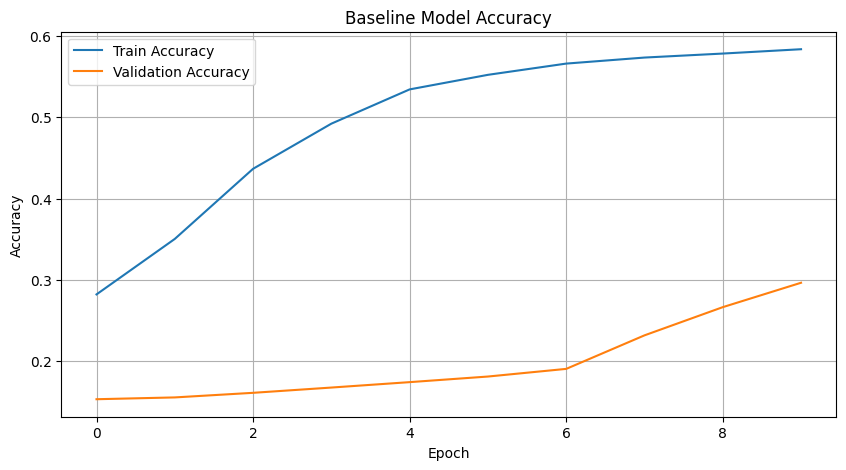

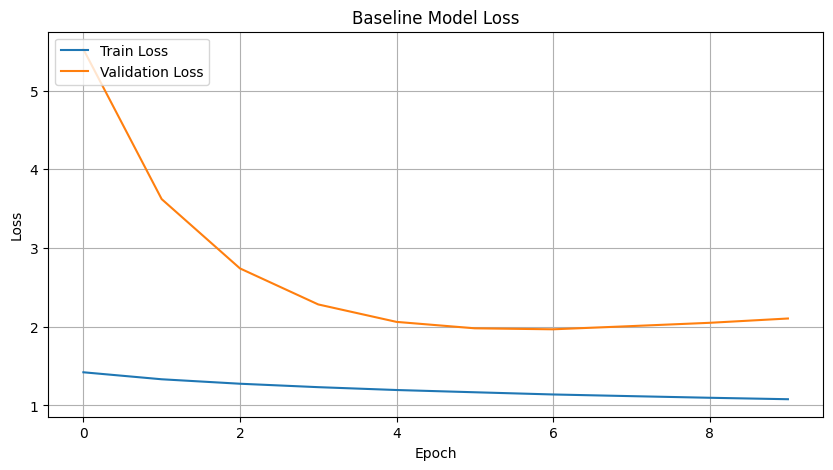

In [17]:
import matplotlib.pyplot as plt

def plot_baseline_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Baseline Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Baseline Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Plot the baseline model performance
plot_baseline_history(baseline_history.history)


In [18]:
def plot_centralized_predictions(x_train, y_train, model, CLASSES, INPUT_SHAPE, PRINT_SAMPLE_PRED=True, PROJECT_FOLDER='./'):
    """
    Plot sample predictions from the centralized model trained on the full dataset.
    
    Args:
        x_train (ndarray): Centralized training data.
        y_train (ndarray): Centralized training labels.
        model (tf.keras.Model): Trained model for making predictions.
        CLASSES (list): List of class names.
        INPUT_SHAPE (tuple): Shape of the input image (e.g., (256, 256, 3)).
        PRINT_SAMPLE_PRED (bool): Whether to print sample predictions.
        PROJECT_FOLDER (str): Directory to save prediction plots.
    """
    if PRINT_SAMPLE_PRED:
        input_idx = np.random.randint(low=0, high=client_data[0][0].shape[0])  # Random index from the centralized training set
        
        x_train_tmp, y_train_tmp = client_data[0]
        
        # Get a random input image and the corresponding real output (label)
        input_img = x_train_tmp[input_idx:input_idx+1]
        real_output = y_train_tmp[input_idx:input_idx+1]

        # Convert real_output to a NumPy array
        real_output = tf.make_ndarray(tf.make_tensor_proto(real_output))  # Convert EagerTensor to NumPy array

        # Make predictions on the selected input image
        y_pred = model.predict(input_img)
        y_pred_conv = np.argmax(y_pred, axis=-1)[0]  # Convert probabilities to class labels

        # Plot the input image
        fig = plt.figure()
        ax = fig.add_subplot(111)
        heatmap = plt.imshow(input_img.reshape(INPUT_SHAPE).astype(int))
        plt.ylabel('Time (ms)')
        plt.xlabel('Frequency (MHz)')
        ax.set_aspect(0.15)
        cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
        plt.colorbar(heatmap, cax=cax)
        plt.show()

        # Plot the real output (ground truth)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        heatmap = plt.imshow(real_output.reshape((256, 256)), cmap='viridis')  # Assuming a grayscale output
        plt.ylabel('Time (ms)')
        plt.xlabel('Frequency (MHz)')
        ax.set_aspect(0.15)
        cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
        cbar = plt.colorbar(heatmap, cax=cax)
        cbar.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate(CLASSES):
            cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
        cbar.ax.get_yaxis().labelpad = 15
        plt.show()

        # Plot the predicted output
        fig = plt.figure()
        ax = fig.add_subplot(111)
        heatmap = plt.imshow(y_pred_conv.reshape((256, 256)), cmap='viridis')
        plt.ylabel('Time (ms)')
        plt.xlabel('Frequency (MHz)')
        ax.set_aspect(0.15)
        cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
        cbar = plt.colorbar(heatmap, cax=cax)
        cbar.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate(CLASSES):
            cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
        cbar.ax.get_yaxis().labelpad = 15
        plt.savefig(PROJECT_FOLDER + 'pred_' + str(input_idx) + '.pdf', bbox_inches='tight')
        plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


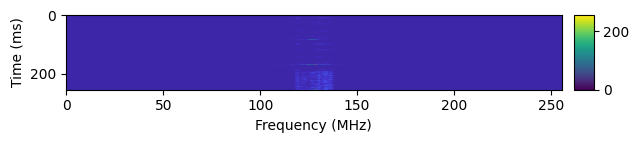

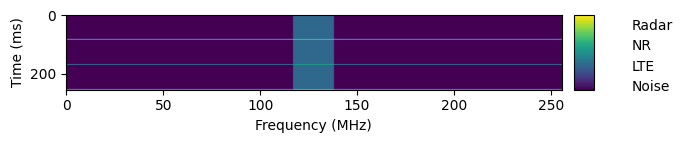

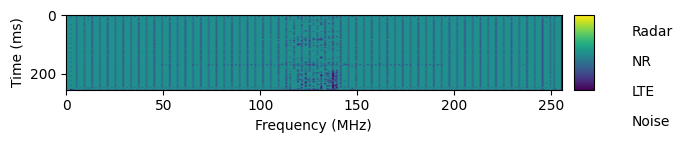

In [19]:
# After training the baseline centralized model
plot_centralized_predictions(x_train, y_train_onehot, baseline_model, CLASSES, INPUT_SHAPE)


# Decenterilazed Federated Learning

In [20]:
# Create directories to store model weights and datasets
os.makedirs('./saved_models', exist_ok=True)
os.makedirs('./saved_datasets', exist_ok=True)

def save_model_and_data(model, client_id, round_num, x_train, y_train, x_val, y_val):
    """
    Save the model weights and training/testing data for each client at each round.
    
    Args:
        model (tf.keras.Model): The trained model to save.
        client_id (int): The client ID.
        round_num (int): The current round number.
        x_train (np.array): Training features for the client.
        y_train (np.array): Training labels for the client.
        x_val (np.array): Validation features for the client.
        y_val (np.array): Validation labels for the client.
    """
    
    # Save training and validation data as numpy files
    if round_num > 18:
        np.save(f'./saved_datasets/client_{client_id}_round_{round_num}_x_train.npy', x_train)
        np.save(f'./saved_datasets/client_{client_id}_round_{round_num}_y_train.npy', y_train)
        np.save(f'./saved_datasets/client_{client_id}_round_{round_num}_x_val.npy', x_val)
        np.save(f'./saved_datasets/client_{client_id}_round_{round_num}_y_val.npy', y_val)
        
        # Save model weights
        model_dir = f'./saved_models/client_{client_id}_round_{round_num}'
        os.makedirs(model_dir, exist_ok=True)
        model.save(os.path.join(model_dir, 'model_weights.keras'))


In [21]:
def model_divergence(model1, model2, method='l2'):
    """
    Calculate the divergence between two models based on their weights, optimized for large models.
    
    Args:
        model1 (tf.keras.Model): The first model.
        model2 (tf.keras.Model): The second model.
        method (str): The divergence method to use ('l2' for L2 norm, 'l1' for L1 norm).
    
    Returns:
        float: The calculated divergence between the two models.
    """
    # Get weights from both models
    weights1 = model1.get_weights()
    weights2 = model2.get_weights()

    divergence = 0
    
    # Iterate over each layer's weights and calculate the divergence incrementally
    for w1, w2 in zip(weights1, weights2):
        if method == 'l2':
            divergence += np.sum((w1 - w2) ** 2)  # Sum of squared differences for L2
        elif method == 'l1':
            divergence += np.sum(np.abs(w1 - w2))  # Sum of absolute differences for L1
        else:
            raise ValueError(f"Unknown method {method}. Supported methods are 'l2' and 'l1'.")
    
    if method == 'l2':
        divergence = np.sqrt(divergence)  # Finalize L2 norm by taking the square root
    
    return divergence


def merge_models_local(models, weights=None, weight_strategy='equal', client_data_sizes=None, client_performances=None):
    """
    Merge models locally by averaging the weights of received models.
    
    Args:
        models (list): List of models received from neighboring clients.
        weights (list): List of predefined weights for averaging (optional).
        weight_strategy (str): The strategy to use for weighting ('equal', 'data_size', 'performance').
        client_data_sizes (list): List of data sizes for each client (needed if strategy is 'data_size').
        client_performances (list): List of performance metrics (e.g., accuracy) for each client (needed if strategy is 'performance').
    
    Returns:
        averaged_model_weights: The merged model's weights.
    """
    model_weights = [model.get_weights() for model in models]
    num_models = len(model_weights)
    avg_weights = model_weights[0]  # Initialize with the first model's weights
    
    # Define the weights based on the specified strategy
    if weight_strategy == 'equal':
        # Equal weighting for all clients
        weights = [1 / num_models] * num_models if weights is None else weights
    elif weight_strategy == 'data_size' and client_data_sizes is not None:
        # Weight models based on the size of data held by each client
        total_data = np.sum(client_data_sizes)
        weights = [size / total_data for size in client_data_sizes]
    elif weight_strategy == 'performance' and client_performances is not None:
        # Weight models based on client performance (e.g., accuracy)
        total_performance = np.sum(client_performances)
        weights = [perf / total_performance for perf in client_performances]
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy} or missing data for the strategy")
    
    # Perform weighted averaging of the model weights
    for layer_idx in range(len(avg_weights)):
        avg_weights[layer_idx] = np.sum([weights[i] * model_weights[i][layer_idx] for i in range(num_models)], axis=0)
    
    return avg_weights


def train_local_model(client_data, model, epochs=1, batch_size=32, num_classes=4):
    """
    Train a local model using the client's data.
    
    Args:
        client_data (tuple): The training data for the client (X_train, y_train).
        model (tf.keras.Model): The model to be trained locally.
        epochs (int): Number of epochs to train for (default is 1 for federated learning).
        batch_size (int): Batch size for training.
        num_classes (int): Number of output classes (for one-hot encoding).
    
    Returns:
        model: The locally trained model.
    """
    X_train, y_train = client_data
    
    # Convert y_train to one-hot encoding if needed
    if len(y_train.shape) == 3:  # If labels are not yet one-hot encoded
        y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Set up early stopping based on validation loss
    early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    
    # Train the model on the local data
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=0, callbacks=[TqdmCallback(verbose=1), early_stop])
    
    return model

# Ensure labels are one-hot encoded before evaluation
def evaluate_model(model, X_val, y_val, num_classes=4):
    """Evaluate the model and ensure that the labels are one-hot encoded."""
    if len(y_val.shape) == 3:  # If labels are not yet one-hot encoded
        y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    
    return model.evaluate(X_val, y_val, verbose=0)

def decentralized_federated_learning(NUM_ROUNDS, client_data, initial_model, num_clients, neighbors_dict,
                                     weight_strategy='equal', client_data_sizes=None, client_performances=None):
    """
    Perform decentralized federated learning while gathering insights.
    
    Args:
        NUM_ROUNDS (int): Number of federated learning rounds.
        client_data (list): List of client datasets.
        initial_model (tf.keras.Model): The model that each client starts with.
        num_clients (int): Number of clients in the network.
        neighbors_dict (dict): Dictionary defining the neighbors for each client.
        weight_strategy (str): The strategy to use for weighting ('equal', 'data_size', 'performance').
        client_data_sizes (list): List of data sizes for each client (needed if strategy is 'data_size').
        client_performances (list): List of performance metrics (e.g., accuracy) for each client (needed if strategy is 'performance').
    
    Returns:
        insights (dict): A dictionary of metrics collected over the training process.
    """
    # Initialize a model for each client
    local_models = [tf.keras.models.clone_model(initial_model) for _ in range(num_clients)]
    for model in local_models:
        model.set_weights(initial_model.get_weights())  # Start with the same weights
    
    insights = {
        "train_acc": [],        # Track train accuracy per client per round
        "val_acc": [],          # Track validation accuracy per client per round
        "divergence": [],       # Track divergence between clients' models before and after merging
        "client_communication": []  # Track how many clients communicated in each round
    }

    for round_num in tqdm(range(NUM_ROUNDS)):
        round_train_acc = []
        round_val_acc = []  # Store the validation accuracy for each client
        round_divergence = []
        
        # Local training for each client
        for i in range(num_clients):
            local_models[i] = train_local_model(client_data[i], local_models[i], epochs=10)
            _, train_acc = evaluate_model(local_models[i], client_data[i][0], client_data[i][1])
            round_train_acc.append(train_acc)
            
            # Save the local model and datasets after training
            X_train, y_train = client_data[i]
            save_model_and_data(local_models[i], i, round_num, X_train, y_train, X_train, y_train)
        
        insights["train_acc"].append(round_train_acc)

        # Decentralized model merging and model divergence tracking
        for i in range(num_clients):
            # Get the models from neighboring clients
            neighbor_models = [local_models[neighbor] for neighbor in neighbors_dict[i]]
            neighbor_models.append(local_models[i])  # Include the client's own model
            
            # Track model divergence before merging
            client_divergence = [model_divergence(local_models[i], neighbor_model) for neighbor_model in neighbor_models]
            round_divergence.append(np.mean(client_divergence))
            
            # Perform the model merging with the specified weighting strategy
            new_weights = merge_models_local(neighbor_models, weight_strategy=weight_strategy, 
                                             client_data_sizes=client_data_sizes, client_performances=client_performances)
            local_models[i].set_weights(new_weights)  # Update client's model with the merged weights
        
        insights["divergence"].append(round_divergence)

        # Evaluate every client's model on the validation set after each round
        for i in range(num_clients):
            _, val_acc = evaluate_model(local_models[i], x_val, y_val_onehot)
            round_val_acc.append(val_acc)
        
        insights["val_acc"].append(round_val_acc)
        
        # Track the number of communications (i.e., number of neighbors contacted)
        num_communications = sum([len(neighbors_dict[i]) for i in range(num_clients)])
        insights["client_communication"].append(num_communications)
        
        # Print progress (average validation accuracy across all clients)
        print(f"Round {round_num + 1}: Train Acc (avg): {np.mean(round_train_acc)}, Val Acc (avg): {np.mean(round_val_acc)}")
        
        if PRINT_SAMPLE_PRED and np.random.randint(0,40)==0:
            x_train_tmp, y_train_tmp = client_data[0]
            input_idx = np.random.randint(low=0,high=x_train_tmp.shape[0])

            input_img = x_train_tmp[input_idx:input_idx+1]
            real_output = y_train_tmp[input_idx:input_idx+1]

            y_pred = local_models[0].predict(input_img)
            #y_pred_conv = np.round(y_pred*2.0)
            y_pred_conv = np.argmax(y_pred, axis=-1)[0]  # Convert probabilities to class labels

            fig = plt.figure()
            ax = fig.add_subplot(111)
            heatmap = plt.imshow(input_img.reshape((256,256,3)).astype(int))
            plt.ylabel('Time (ms)')
            plt.xlabel('Frequency (MHz)')
            ax.set_aspect(0.15)
            cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
            plt.colorbar(heatmap, cax=cax)
            plt.show()

            fig = plt.figure()
            ax = fig.add_subplot(111)
            heatmap = plt.imshow(real_output.reshape((256,256)), cmap=cmp)
            plt.ylabel('Time (ms)')
            plt.xlabel('Frequency (MHz)')
            ax.set_aspect(0.15)
            cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
            cbar = plt.colorbar(heatmap, cax=cax)
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate(CLASSES):
                cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
            cbar.ax.get_yaxis().labelpad = 15
            plt.show()

            fig = plt.figure()
            ax = fig.add_subplot(111)
            heatmap = plt.imshow(y_pred_conv.reshape((256,256)), cmap=cmp)
            plt.ylabel('Time (ms)')
            plt.xlabel('Frequency (MHz)')
            ax.set_aspect(0.15)
            cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
            cbar = plt.colorbar(heatmap, cax=cax)
            cbar = plt.colorbar(heatmap, cax=cax)
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate(CLASSES):
                cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
            cbar.ax.get_yaxis().labelpad = 15
            plt.savefig(PROJECT_FOLDER + 'pred_' + str(i) + '.pdf' ,bbox_inches='tight')
            plt.show()

            eval = evaluate_segmentation(real_output.reshape((256,256)), y_pred_conv.reshape((256,256)), CLASSES)
            fig, axes = eval.show_confusion_matrix()
            plt.show()

    return insights

In [22]:
def save_results_to_file(results, file_format='json', filename='experiment_results'):
    """
    Save the results to a file after each iteration.
    
    Args:
        results (list): The list of results collected so far.
        file_format (str): The file format to use for saving ('json' or 'pickle').
        filename (str): The base filename for saving the results.
    """
    if file_format == 'json':
        with open(f'{filename}.json', 'a') as json_file:
            json.dump(results, json_file, indent=4)
    elif file_format == 'pickle':
        with open(f'{filename}.pkl', 'ab') as pickle_file:
            pickle.dump(results, pickle_file)

In [23]:
def run_multiple_experiments(num_experiments, num_rounds, client_data, initial_model, num_clients, neighbors_dict, weight_strategy='equal', file_format='json', filename='experiment_results'):
    """
    Run multiple experiments and save the results incrementally.
    
    Args:
        num_experiments (int): The number of experiments to run.
        num_rounds (int): The number of rounds to perform in each experiment.
        client_data (list): The client datasets.
        initial_model (tf.keras.Model): The initial model for each experiment.
        num_clients (int): The number of clients.
        neighbors_dict (dict): The neighbors for each client.
        weight_strategy (str): The strategy to use for weighting ('equal', 'data_size', 'performance').
        file_format (str): The file format to use for saving ('json' or 'pickle').
        filename (str): The base filename for saving the results.
    
    Returns:
        results (list): The list of results from all experiments.
    """
    results = []  # To store insights from each run
    
    # Run the experiment multiple times
    for exp_num in range(num_experiments):
        print(f"Running Experiment {exp_num + 1}/{num_experiments}...")
        
        client_data_sizes = [len(data[0]) for data in client_data]  # Calculate client data sizes
        
        # Perform the experiment
        insights = decentralized_federated_learning(NUM_ROUNDS=num_rounds, client_data=client_data, 
                                                    initial_model=initial_model, num_clients=num_clients, 
                                                    neighbors_dict=neighbors_dict, weight_strategy=weight_strategy, 
                                                    client_data_sizes=client_data_sizes)
        
        # Collect the insights from this run
        results.append({
            "experiment": exp_num + 1,
            "train_acc": insights["train_acc"],
            "val_acc": insights["val_acc"],
            "divergence": insights["divergence"],
            "client_communication": insights["client_communication"]
        })
        
        # Save the results to a file after each experiment
        save_results_to_file(results, file_format=file_format, filename=filename)
    
    return results

In [24]:
# Build and compile the U-Net model
global_model = build_unet(INPUT_SHAPE, NUM_CLASSES)
global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Example topology and usage
neighbors_dict = {
    0: [1, 4],  # Client 0 communicates with Client 1 and Client 4
    1: [0, 2],  # Client 1 communicates with Client 0 and Client 2
    2: [1, 3],  # Client 2 communicates with Client 1 and Client 3
    3: [2, 4],  # Client 3 communicates with Client 2 and Client 4
    4: [0, 3],  # Client 4 communicates with Client 0 and Client 3
}



In [25]:
# Example usage: Run the experiment 5 times with 20 rounds each and save results as JSON
num_experiments = 1
num_rounds = 40
experiment_results = run_multiple_experiments(num_experiments, num_rounds, client_data, global_model, 
                                              num_clients=5, neighbors_dict=neighbors_dict, weight_strategy='equal',
                                              file_format='json', filename='experiment_results')


Running Experiment 1/1...


  0%|          | 0/40 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 1: Train Acc (avg): 0.2776164084672928, Val Acc (avg): 0.3002276599407196


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 2: Train Acc (avg): 0.3160227298736572, Val Acc (avg): 0.3212536573410034


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 3: Train Acc (avg): 0.47617424130439756, Val Acc (avg): 0.33416265845298765


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 4: Train Acc (avg): 0.4471853494644165, Val Acc (avg): 0.35896472334861756


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 5: Train Acc (avg): 0.6273256719112397, Val Acc (avg): 0.4808048665523529


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 6: Train Acc (avg): 0.6118295013904571, Val Acc (avg): 0.5537091016769409


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 7: Train Acc (avg): 0.6495751440525055, Val Acc (avg): 0.7075607180595398


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 8: Train Acc (avg): 0.7767449736595153, Val Acc (avg): 0.8056543588638305


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 9: Train Acc (avg): 0.7693074345588684, Val Acc (avg): 0.8219760775566101


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 10: Train Acc (avg): 0.7864487648010254, Val Acc (avg): 0.7532102704048157


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 11: Train Acc (avg): 0.8393730163574219, Val Acc (avg): 0.8393183708190918


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 12: Train Acc (avg): 0.7388055086135864, Val Acc (avg): 0.796026599407196


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 13: Train Acc (avg): 0.8527176737785339, Val Acc (avg): 0.857476007938385


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 14: Train Acc (avg): 0.7863840222358703, Val Acc (avg): 0.8549023985862731


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 15: Train Acc (avg): 0.7093639433383941, Val Acc (avg): 0.8301056504249573


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 16: Train Acc (avg): 0.8428208827972412, Val Acc (avg): 0.8592282891273498


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 17: Train Acc (avg): 0.8234189271926879, Val Acc (avg): 0.8606400728225708


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 18: Train Acc (avg): 0.8441444993019104, Val Acc (avg): 0.8879719614982605


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 19: Train Acc (avg): 0.8789278030395508, Val Acc (avg): 0.8899562239646912


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 20: Train Acc (avg): 0.8975979804992675, Val Acc (avg): 0.8912460446357727


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 21: Train Acc (avg): 0.897884464263916, Val Acc (avg): 0.891866147518158


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Round 22: Train Acc (avg): 0.869050669670105, Val Acc (avg): 0.8887857556343078


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

OSError: 20971520 requested and 0 written

In [ ]:
# Example usage: Run the experiment 5 times with 20 rounds each and save results as JSON
num_experiments = 1
num_rounds = 40
experiment_results_data_size = run_multiple_experiments(num_experiments, num_rounds, client_data, global_model, 
                                              num_clients=5, neighbors_dict=neighbors_dict, weight_strategy='data_size',
                                              file_format='json', filename='experiment_results_data_size')


In [ ]:
# Example usage: Run the experiment 5 times with 20 rounds each and save results as JSON
num_experiments = 5
num_rounds = 20
experiment_results_performance = run_multiple_experiments(num_experiments, num_rounds, client_data, global_model, 
                                              num_clients=5, neighbors_dict=neighbors_dict, weight_strategy='performance',
                                              file_format='json', filename='experiment_results_performance')


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import json

def correct_json_format(input_file, output_file):
    """
    Reformat JSON file by treating each JSON object as a separate entry
    in an array, then saving it as a valid JSON array.

    Args:
        input_file (str): Path to the original JSON file with individual JSON objects.
        output_file (str): Path to save the corrected JSON file.
    """
    experiments = []
    with open(input_file, 'r') as file:
        content = file.read()
        items = content.split("}\n{")  # Split where JSON objects might be separated incorrectly

        # Reformat each block
        for idx, item in enumerate(items):
            # Add missing braces at the beginning or end
            if idx == 0:
                item = item + "}"
            elif idx == len(items) - 1:
                item = "{" + item
            else:
                item = "{" + item + "}"
                
            # Attempt to parse and add to list
            try:
                experiments.append(json.loads(item))
            except json.JSONDecodeError:
                print(f"Error parsing JSON block: {item}")

    # Save as a valid JSON array
    with open(output_file, 'w') as outfile:
        json.dump(experiments, outfile, indent=4)
    print(f"Corrected JSON format saved to {output_file}")

def load_experiment_results(filename):
    """Load experiment results from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

def plot_model_divergence(data_equal, data_data_size):
    """
    Plot model divergence over rounds for different weighting strategies
    with multiple experiments in each dataset.
    
    Args:
        data_equal (list): Results for the 'equal' weighting strategy.
        data_data_size (list): Results for the 'data_size' weighting strategy.
    """
    num_rounds = len(data_equal[0]["divergence"])  # Number of rounds in each experiment

    # Initialize lists to store averaged divergence across experiments for each round
    avg_divergence_equal = []
    avg_divergence_data_size = []
    
    # Calculate average divergence per round for each weighting strategy
    for round_num in range(num_rounds):
        # Collect divergence for each experiment in the current round
        round_divergence_equal = [
            np.mean(exp["divergence"][round_num]) for exp in data_equal if "divergence" in exp
        ]
        round_divergence_data_size = [
            np.mean(exp["divergence"][round_num]) for exp in data_data_size if "divergence" in exp
        ]
        
        # Average across all experiments for the current round
        avg_divergence_equal.append(np.mean(round_divergence_equal))
        avg_divergence_data_size.append(np.mean(round_divergence_data_size))
    
    # Plotting
    rounds = np.arange(1, num_rounds + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, avg_divergence_equal, label='Equal Weighting', marker='o')
    plt.plot(rounds, avg_divergence_data_size, label='Data-Size Weighting', marker='x')
    plt.xlabel("Federated Learning Round")
    plt.ylabel("Average Model Divergence")
    plt.title("Comparison of Model Divergence with Different Weighting Strategies")
    plt.legend()
    plt.grid(True)
    plt.show()

# Specify file paths
input_file_equal = 'experiment_results.json'
output_file_equal_corrected = 'experiment_results_corrected.json'

input_file_data_size = 'experiment_results_data_size.json'
output_file_data_size_corrected = 'experiment_results_data_size_corrected.json'

# Run the correction function on both files
correct_json_format(input_file_equal, output_file_equal_corrected)
correct_json_format(input_file_data_size, output_file_data_size_corrected)


# Load data from JSON files
data_equal = load_experiment_results(output_file_equal_corrected)
data_data_size = load_experiment_results(output_file_data_size_corrected)

# Plot model divergence
plot_model_divergence(data_equal, data_data_size)


In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split JSON blocks and save each as a separate file
def split_json_file(input_file, output_dir):
    with open(input_file, 'r') as file:
        data = file.read()
    
    json_blocks = data.split('\n][\n')  # Splits at the start of each new JSON array block

    # Save each block as a separate JSON file in the output directory
    for i, block in enumerate(json_blocks):
        block = block[1:]
        output_path = os.path.join(output_dir, f'experiment_{i+1}.json')
        with open(output_path, 'w') as output_file:
            output_file.write(block)
            


# Step 2: Load JSON files into a DataFrame
def load_json_to_dataframe(directory):
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    df_list = []
    
    for file in json_files:
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Flatten the data and append to list


        flattened_data = {
            "experiment": data["experiment"],
            "train_acc": data["train_acc"],
            "val_acc": data["val_acc"],
            "divergence": data["divergence"],
            "client_communication": data["client_communication"]
        }
        df_list.append(flattened_data)
    
    # Convert list to DataFrame
    df = pd.DataFrame(df_list)
    return df


    

In [ ]:
# Step 3: Expand `train_acc`, `val_acc`, and `divergence` columns
def expand_dataframe(df):
    # Lists to store expanded rows
    expanded_rows = []

    # Loop over each experiment
    for _, row in df.iterrows():
        experiment_no = row['experiment']
        
        # Get the number of rounds
        num_rounds = len(row['train_acc'])
        
        # Expand each round's data
        for round_num in range(num_rounds):
            expanded_rows.append({
                "experiment": experiment_no,
                "round": round_num + 1,  # Start round numbering from 1
                "train_acc": row['train_acc'][round_num],
                "val_acc": row['val_acc'][round_num],
                "divergence": row['divergence'][round_num]
            })
    
    # Create an expanded DataFrame
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df

# Step 4: Plot the model divergence using the expanded DataFrame
def plot_model_divergence(expanded_df):
    # Flatten divergence for each round and experiment
    divergence_data = expanded_df.explode('divergence')
    
    # Convert `divergence` column to float for plotting
    divergence_data['divergence'] = divergence_data['divergence'].astype(float)
    divergence_data['round'] = divergence_data['round'].astype(int)
    
    # Plotting the divergence using Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=divergence_data, x='round', y='divergence', marker='o')
    plt.xlabel('Round')
    plt.ylabel('Divergence')
    plt.title('Model Divergence Over Rounds for Each Experiment')
    plt.grid(True)
    plt.legend(title='Experiment')
    plt.show()

# Step 4: Plot train and validation accuracy over rounds
def plot_accuracy(expanded_df):
    # Explode `train_acc` and `val_acc` so each round has a separate entry
    train_data = expanded_df.explode('train_acc')
    val_data = expanded_df.explode('val_acc')
    
    # Convert `train_acc` and `val_acc` to float for plotting
    train_data['train_acc'] = train_data['train_acc'].astype(float)
    val_data['val_acc'] = val_data['val_acc'].astype(float)
    train_data['round'] = train_data['round'].astype(int)
    val_data['round'] = val_data['round'].astype(int)

    # Plotting train accuracy
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=train_data, x='round', y='train_acc', hue='experiment', marker='o')
    plt.xlabel('Round')
    plt.ylabel('Train Accuracy')
    plt.title('Training Accuracy Over Rounds for Each Experiment')
    plt.grid(True)
    plt.legend(title='Experiment')
    plt.show()

    # Plotting validation accuracy
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=val_data, x='round', y='val_acc', hue='experiment', marker='o')
    plt.xlabel('Round')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy Over Rounds for Each Experiment')
    plt.grid(True)
    plt.legend(title='Experiment')
    plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure plotting style for publication
sns.set_context("talk", font_scale=1.2)  # Larger font scale
sns.set_style("whitegrid")  # Grid style suitable for scientific plots
palette = sns.color_palette("colorblind")  # Colorblind-friendly palette

# Step 3: Expand `train_acc`, `val_acc`, and `divergence` columns
def expand_dataframe(df):
    expanded_rows = []
    for _, row in df.iterrows():
        experiment_no = row['experiment']
        num_rounds = len(row['train_acc'])
        for round_num in range(num_rounds):
            expanded_rows.append({
                "experiment": experiment_no,
                "round": round_num + 1,
                "train_acc": row['train_acc'][round_num],
                "val_acc": row['val_acc'][round_num],
                "divergence": row['divergence'][round_num]
            })
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df

# Step 4a: Plot model divergence using expanded DataFrame
def plot_model_divergence(expanded_df):
    divergence_data = expanded_df.explode('divergence')
    divergence_data['divergence'] = divergence_data['divergence'].astype(float)
    divergence_data['round'] = divergence_data['round'].astype(int)

    plt.figure(figsize=(10, 6), dpi=150)
    sns.lineplot(data=divergence_data, x='round', y='divergence', #hue='experiment', 
                 marker='o', palette=palette, linewidth=2)
    plt.xlabel('Round', fontsize=18)
    plt.ylabel('Model Divergence', fontsize=18)
    # plt.title('Model Divergence Over Rounds for Each Experiment', fontsize=16, weight='bold')
    #plt.legend(title='Experiment', loc='upper right', fontsize=10, title_fontsize='13')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.savefig('model_divergence.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

# Step 4b: Plot training and validation accuracy over rounds
def plot_accuracy(expanded_df):
    train_data = expanded_df.explode('train_acc')
    val_data = expanded_df.explode('val_acc')
    train_data['train_acc'] = train_data['train_acc'].astype(float)
    val_data['val_acc'] = val_data['val_acc'].astype(float)
    train_data['round'] = train_data['round'].astype(int)
    val_data['round'] = val_data['round'].astype(int)

    # Plot training accuracy
    plt.figure(figsize=(10, 6), dpi=150)
    sns.lineplot(data=train_data, x='round', y='train_acc', #hue='experiment', 
                 marker='o', palette=palette, linewidth=2)
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Training Accuracy (%)', fontsize=18)
    # plt.title('Training Accuracy Over Rounds for Each Experiment', fontsize=16, weight='bold')
    #plt.legend(title='Experiment', loc='lower right', fontsize=10, title_fontsize='13')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.savefig('train_accuracy.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 6), dpi=150)
    sns.lineplot(data=val_data, x='round', y='val_acc', #hue='experiment', 
                 marker='o', palette=palette, linewidth=2)
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Validation Accuracy (%)', fontsize=18)
    # plt.title('Validation Accuracy Over Rounds for Each Experiment', fontsize=16, weight='bold')
    #plt.legend(title='Experiment', loc='lower right', fontsize=10, title_fontsize='13')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.savefig('val_accuracy.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()


In [ ]:
# Define the input file and the output directory
input_file = 'experiment_results.json'  # Change this to your specific file if needed
output_dir = './tmp'
os.makedirs(output_dir, exist_ok=True)

# Execute splitting
split_json_file(input_file, output_dir)

# Load all JSON data into a single DataFrame
df = load_json_to_dataframe(output_dir)

# Expand the DataFrame
expanded_df = expand_dataframe(df)

# Plot the model divergence
plot_model_divergence(expanded_df)

# Plot the accuracy
plot_accuracy(expanded_df)

In [ ]:
# Define the input file and the output directory
input_file = 'experiment_results_data_size.json'  # Change this to your specific file if needed
output_dir = './tmp'
os.makedirs(output_dir, exist_ok=True)

# Execute splitting
# split_json_file(input_file, output_dir)

# Load all JSON data into a single DataFrame
df = load_json_to_dataframe(output_dir)

# Expand the DataFrame
expanded_df = expand_dataframe(df)

# Plot the model divergence
plot_model_divergence(expanded_df)

# Plot the accuracy
plot_accuracy(expanded_df)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Define directories for saved models and datasets
model_dir = "./saved_models"
dataset_dir = "./saved_datasets"

# Define list to hold evaluation results
results = []

# Iterate over each client directory, skipping non-model directories
for client_folder in os.listdir(model_dir):
    client_folder_path = os.path.join(model_dir, client_folder)
    # Skip non-directory files like .DS_Store
    if not os.path.isdir(client_folder_path):
        continue

    # Get the client ID and round number from the folder name
    client_id = client_folder.split('_')[1]
    round_num = client_folder.split('_')[-1]
    
    # Path to the model weights
    model_path = os.path.join(client_folder_path, "model_weights.keras")
    # Check if the model file exists
    if not os.path.exists(model_path):
        print(f"Model file not found for {client_folder}, skipping...")
        continue

    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Load validation data
    x_val_path = os.path.join(dataset_dir, f"client_{client_id}_round_{round_num}_x_val.npy")
    y_val_path = os.path.join(dataset_dir, f"client_{client_id}_round_{round_num}_y_val.npy")
    
    # Check if validation data exists
    if not os.path.exists(x_val_path) or not os.path.exists(y_val_path):
        print(f"Validation data not found for {client_folder}, skipping...")
        continue

    X_val = np.load(x_val_path)
    y_val = np.load(y_val_path)
    
    # Ensure y_val is in one-hot format or convert it if necessary
    if y_val.ndim > 2 and y_val.shape[-1] > 1:
        y_true_classes = np.argmax(y_val, axis=-1).flatten()  # Flatten for pixel-wise comparison
    else:
        y_true_classes = y_val.flatten()  # Already in class format

    # Predict using the model
    y_pred = model.predict(X_val, verbose=0)
    # Make predictions on the selected input image
    y_pred = np.argmax(y_pred, axis=-1)[0]  # Convert probabilities to class labels

    y_pred_classes = np.argmax(y_pred, axis=-1).flatten()  # Flatten to get class predictions per pixel
    
    # Ensure y_true_classes and y_pred_classes have the same length
    if y_true_classes.shape[0] != y_pred_classes.shape[0]:
        min_length = min(y_true_classes.shape[0], y_pred_classes.shape[0])
        y_true_classes = y_true_classes[:min_length]
        y_pred_classes = y_pred_classes[:min_length]
    
    # Calculate pixel-wise accuracy
    pixel_accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    # Calculate IoU for each class and then average, weighted by support
    iou_score = jaccard_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Calculate additional metrics if needed (weighted precision, recall, F1)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Append results to the list
    results.append({
        "Client": client_id,
        "Round": round_num,
        "Pixel Accuracy": pixel_accuracy,
        "Mean IoU": iou_score,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convert results to DataFrame for a clear table format
results_df = pd.DataFrame(results)

# Display the results table
results_df.sort_values(by=["Client", "Round"], inplace=True)
print(results_df)


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Define directories for saved models and datasets
model_dir = "./saved_models"
dataset_dir = "./saved_datasets"

# Define class names for better readability
CLASSES = ["Noise", "LTE", "NR", "Radar"]

# Define list to hold evaluation results
results = []

# Iterate over each client directory, skipping non-model directories
for client_folder in os.listdir(model_dir):
    client_folder_path = os.path.join(model_dir, client_folder)
    if not os.path.isdir(client_folder_path):
        continue

    # Get the client ID and round number from the folder name
    client_id = client_folder.split('_')[1]
    round_num = client_folder.split('_')[-1]
    
    # Path to the model weights
    model_path = os.path.join(client_folder_path, "model_weights.keras")
    if not os.path.exists(model_path):
        print(f"Model file not found for {client_folder}, skipping...")
        continue

    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Load validation data
    x_val_path = os.path.join(dataset_dir, f"client_{client_id}_round_{round_num}_x_val.npy")
    y_val_path = os.path.join(dataset_dir, f"client_{client_id}_round_{round_num}_y_val.npy")
    
    if not os.path.exists(x_val_path) or not os.path.exists(y_val_path):
        print(f"Validation data not found for {client_folder}, skipping...")
        continue

    X_val = np.load(x_val_path)
    y_val = np.load(y_val_path)
    
    # Flatten the true labels for pixel-wise comparison
    y_true_classes = np.argmax(y_val, axis=-1).flatten() if y_val.ndim > 2 and y_val.shape[-1] > 1 else y_val.flatten()

    # Predict using the model
    y_pred = model.predict(X_val, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=-1).flatten()

    # Ensure matching lengths for metrics calculation
    min_length = min(y_true_classes.shape[0], y_pred_classes.shape[0])
    y_true_classes = y_true_classes[:min_length]
    y_pred_classes = y_pred_classes[:min_length]

    # Calculate per-class metrics
    iou_per_class = jaccard_score(y_true_classes, y_pred_classes, average=None, labels=range(len(CLASSES)))
    precision_per_class = precision_score(y_true_classes, y_pred_classes, average=None, labels=range(len(CLASSES)))
    recall_per_class = recall_score(y_true_classes, y_pred_classes, average=None, labels=range(len(CLASSES)))
    f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None, labels=range(len(CLASSES)))

    # Store results for each class
    for class_idx, class_name in enumerate(CLASSES):
        results.append({
            "Client": client_id,
            "Round": round_num,
            "Class": class_name,
            "IoU": iou_per_class[class_idx],
            "Precision": precision_per_class[class_idx],
            "Recall": recall_per_class[class_idx],
            "F1 Score": f1_per_class[class_idx]
        })

# Convert results to DataFrame for a clear table format
results_df = pd.DataFrame(results)

# Display the results table, sorted by client and round
results_df.sort_values(by=["Client", "Round", "Class"], inplace=True)
print(results_df)


In [ ]:
import os
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score
from scipy.spatial.distance import directed_hausdorff
from skimage.metrics import adapted_rand_error as dice_coefficient
from skimage.measure import label, regionprops
from medpy.metric.binary import dc, hd, assd, volume_correlation

# Define a function to calculate the metrics for each class
def calculate_segmentation_metrics(y_true, y_pred, classes):
    metrics = {}

    for class_idx, class_name in enumerate(classes):
        y_true_class = (y_true == class_idx).astype(int)
        y_pred_class = (y_pred == class_idx).astype(int)

        # Dice coefficient
        dice = dc(y_pred_class, y_true_class)
        
        # Jaccard index (IoU)
        jaccard = jaccard_score(y_true_class.flatten(), y_pred_class.flatten())

        # Sensitivity (Recall)
        sensitivity = recall_score(y_true_class.flatten(), y_pred_class.flatten())

        # Specificity
        tn = np.sum((y_true_class == 0) & (y_pred_class == 0))
        fp = np.sum((y_true_class == 0) & (y_pred_class == 1))
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Precision
        precision = precision_score(y_true_class.flatten(), y_pred_class.flatten())

        # Accuracy
        accuracy = accuracy_score(y_true_class.flatten(), y_pred_class.flatten())

        # Mean Surface Distance (Average Symmetric Surface Distance)
        mean_surface_distance = assd(y_true_class, y_pred_class)

        # Hausdorff Distance
        hausdorff_distance = hd(y_true_class, y_pred_class)

        # Volume Difference (difference in number of pixels)
        true_volume = np.sum(y_true_class)
        predicted_volume = np.sum(y_pred_class)
        volume_difference = np.abs(true_volume - predicted_volume)

        # Store all metrics for this class
        metrics[class_name] = {
            "Dice": dice,
            "Jaccard": jaccard,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Precision": precision,
            "Accuracy": accuracy,
            "Mean Surface Distance": mean_surface_distance,
            "Hausdorff Distance": hausdorff_distance,
            "Volume Difference": volume_difference,
            "True Volume": true_volume,
            "Predicted Volume": predicted_volume
        }
    
    return metrics


In [ ]:
# Get a random input image and the corresponding real output (label)
input_idx = np.random.randint(X_val.shape[0])
input_img = X_val[input_idx:input_idx+1]
real_output = y_val[input_idx:input_idx+1]

# Get the client ID and round number from the folder name
client_id = np.random.randint(NUMBER_OF_CLIENTS)

# Path to the model weights
model_path = os.path.join("./saved_models/client_" + str(client_id) + "_round_38/", "model_weights.keras")
model = tf.keras.models.load_model(model_path)

# Convert real_output to a NumPy array
real_output = tf.make_ndarray(tf.make_tensor_proto(real_output))  # Convert EagerTensor to NumPy array

# Make predictions on the selected input image
y_pred = model.predict(input_img)
y_pred_conv = np.argmax(y_pred, axis=-1)[0]  # Convert probabilities to class labels

# Plot the input image
fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(input_img.reshape(INPUT_SHAPE).astype(int))
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
plt.colorbar(heatmap, cax=cax)
plt.show()

# Plot the real output (ground truth)
fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(real_output.reshape((256, 256)), cmap='viridis')  # Assuming a grayscale output
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cbar = plt.colorbar(heatmap, cax=cax)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(CLASSES):
    cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 15
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(y_pred_conv.reshape((256,256)), cmap=cmp)
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(heatmap, cax=cax)
cbar = plt.colorbar(heatmap, cax=cax)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(CLASSES):
    cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 15
plt.show()


metrics = calculate_segmentation_metrics(real_output.reshape((256, 256)), y_pred_conv.reshape((256,256)), CLASSES)

# Display metrics
for class_name, class_metrics in metrics.items():
    print(f"Metrics for {class_name}:")
    for metric_name, value in class_metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("\n")


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from medpy.metric.binary import dc, hd, assd

# Define directories for saved models and datasets
model_dir = "./saved_models"
dataset_dir = "./saved_datasets"

# Define class names for better readability
CLASSES = ["Noise", "LTE", "NR", "Radar"]

# Define a function to calculate metrics for each class
def calculate_segmentation_metrics(y_true, y_pred, classes):
    metrics = {class_name: {} for class_name in classes}

    for class_idx, class_name in enumerate(classes):
        y_true_class = (y_true == class_idx).astype(int)
        y_pred_class = (y_pred == class_idx).astype(int)

        # Dice coefficient
        metrics[class_name]["Dice"] = dc(y_pred_class, y_true_class)

        # Jaccard index (IoU)
        metrics[class_name]["IoU"] = jaccard_score(y_true_class.flatten(), y_pred_class.flatten())

        # Sensitivity (Recall)
        metrics[class_name]["Sensitivity"] = recall_score(y_true_class.flatten(), y_pred_class.flatten())

        # Specificity
        tn = np.sum((y_true_class == 0) & (y_pred_class == 0))
        fp = np.sum((y_true_class == 0) & (y_pred_class == 1))
        metrics[class_name]["Specificity"] = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Precision
        metrics[class_name]["Precision"] = precision_score(y_true_class.flatten(), y_pred_class.flatten())

        # Accuracy
        metrics[class_name]["Accuracy"] = accuracy_score(y_true_class.flatten(), y_pred_class.flatten())

        # Mean Surface Distance
        # metrics[class_name]["Mean Surface Distance"] = assd(y_true_class, y_pred_class)

        # Hausdorff Distance
        # metrics[class_name]["Hausdorff Distance"] = hd(y_true_class, y_pred_class)

        # Volume Difference
        true_volume = np.sum(y_true_class)
        predicted_volume = np.sum(y_pred_class)
        metrics[class_name]["Volume Difference"] = abs(true_volume - predicted_volume)
        metrics[class_name]["True Volume"] = true_volume
        metrics[class_name]["Predicted Volume"] = predicted_volume
    
    return metrics

# Define list to hold all metrics for each class and each image
all_results = []

# Iterate over each client directory, skipping non-model directories
for client_folder in tqdm(os.listdir(model_dir)):
    client_folder_path = os.path.join(model_dir, client_folder)
    if not os.path.isdir(client_folder_path):
        continue

    # Get the client ID and round number from the folder name
    client_id = client_folder.split('_')[1]
    round_num = client_folder.split('_')[-1]
    
    # Path to the model weights
    model_path = os.path.join(client_folder_path, "model_weights.keras")
    if not os.path.exists(model_path):
        print(f"Model file not found for {client_folder}, skipping...")
        continue

    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Load validation data
    x_val_path = os.path.join(dataset_dir, f"client_{client_id}_round_{round_num}_x_val.npy")
    y_val_path = os.path.join(dataset_dir, f"client_{client_id}_round_{round_num}_y_val.npy")
    
    if not os.path.exists(x_val_path) or not os.path.exists(y_val_path):
        print(f"Validation data not found for {client_folder}, skipping...")
        continue

    X_val = np.load(x_val_path)
    y_val = np.load(y_val_path)

    # Process each validation image individually
    for img_idx in tqdm(range(X_val.shape[0])):
        input_img = X_val[img_idx:img_idx + 1]
        real_output = y_val[img_idx]
        
        # Predict using the model
        y_pred = model.predict(input_img, verbose=0)
        y_pred_class = np.argmax(y_pred, axis=-1)[0]

        # Calculate per-class metrics for this image
        metrics = calculate_segmentation_metrics(real_output, y_pred_class, CLASSES)

        # Store results for each class
        for class_name, class_metrics in metrics.items():
            all_results.append({
                "Client": client_id,
                "Round": round_num,
                "Class": class_name,
                **class_metrics
            })

# Convert all_results to DataFrame
all_results_df = pd.DataFrame(all_results)



In [ ]:
# Calculate the average metrics for each class across all images
average_results_df = all_results_df.groupby(["Class","Client","Round"]).mean().reset_index()

# Display the final table of average metrics
print(average_results_df)

# Generate LaTeX code if needed
latex_code = average_results_df.to_latex(index=False, float_format="%.4f", caption="Average Segmentation Metrics per Class", label="tab:segmentation_metrics")
print("\nLaTeX Table Code:")
print(latex_code)


In [ ]:
all_results_df.info()